# Across-Sessions Within Subject Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we are going to look at how to implement the across sessions within subject testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).
This test is used for studying variability between different sessions in studies spanning multiple scanning sessions and is therefore ideal for longitudinal studies.

In the real world scenarios, one would typically fit a Hidden Markov Model (HMM) to an actual dataset. However, for the sake of showing the concept of statistical testing, we just use synthetic data for both the independent variable  and the dependent variable for the ```across_sessions_within_subject``` test.

We create synthetic data using the toolbox [Genephys](https://github.com/vidaurre/genephys), developed by Vidaurre in 2023 (accessible at [https://doi.org/10.7554/eLife.87729.2](https://elifesciences.org/reviewed-preprints/87729)). 
[Genephys](https://github.com/vidaurre/genephys) makes it possible to simulate electrophysiological data in the context of a psychometric experiment. Hence, it can create scenarios where, for example, a subject is exposed to one or multiple stimuli while simultaneously recording EEG or MEG data.

While the process of preparing the data requires some explanation, executing the test (```across_sessions_within_subject```) itself is straightforward —simply input the variables ```D``` and ```R```, and define the specific ```method``` you wish to apply. The methods include permutation using regression or permutation using correlation and is described in the paper [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time).

## Table of Contents
1. [Load and prepare data](#load-data)
    * [Look at data](#look-data)
    * [Prepare data for HMM](#prep_hmm)
2. [Load data or initialise and train HMM](#load_hmm)
    * [Data restructuring](#data-recon)
3. [Across-sessions within subject testing](#across_sessions)
    * [Across-sessions within subject testing - Regression](#perm-regression)
    * [Across-sessions within subject testing - Correlation](#perm-correlation)

### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

To use the function ```glhmm.statistics.py``` you also need to install the library's:
```
pip install statsmodels
``` 
```
pip install tqdm
```
``` 
pip install -U scikit-image
``` 

``` 

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
import os
import numpy as np
import pandas as pd
from glhmm import glhmm, graphics, statistics,preproc

## 1. Load and prepare data <a id="load-data"></a>
First, we'll load the synthetic data from this [folder](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) and use the [glhmm toolbox](https://github.com/vidaurre/glhmm) to train a classic HMM on the synthetic data that represents EEG or MEG measurements.\
Let's start by loading the essential data for this tutorial:

In [2]:
# Get the current directory
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Load D data
file_name = '\\D_sessions.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
D_sessions = np.load(file_path)

# Load R data
file_name = '\\R_sessions.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
R_sessions = np.load(file_path)

# Load indices
file_name = '\\idx_sessions.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
idx_sessions = np.load(file_path)


print(f"Data dimension of D-session data: {D_sessions.shape}")
print(f"Data dimension of R-session data: {R_sessions.shape}")
print(f"Data dimension of indices: {idx_sessions.shape}")

Data dimension of D-session data: (250, 1500, 16)
Data dimension of R-session data: (1500,)
Data dimension of indices: (10, 2)


### Look at data <a id="look-data"></a>
Now we can look at the data structure.
- D_sessions: 3D array of shape (n_timepoints, n_trials, n_features)
- R_sessions: 3D array of shape (n_trials,)
- idx_sessions: 2D array of shape (n_sessions, 2)

```D_sessions``` represents the data collected from the subject, structured as a list with three elements: ```[250, 1500, 16]```. The first element indicates that the subject underwent measurement across ```250``` timepoints. The second element, ```1500```, corresponds to the total number of trials conducted. In this context, 10 distinct sessions were executed, each comprising 150 trials, lead up to a total of 1500 trials (150*10). Each individual trial involved the measurement of ```16``` channels within the EEG or MEG scanner.

```R_sessions``` simulates the measured reaction time for each trial that the subject undergoes at different sessions. 

Lastly, we have ```idx_sessions = [10, 2]```. This indicates the number of sessions conducted, which in this case is ```10```. The values in each row represent the start and end indices of the trials.



### Prepare data for HMM <a id="prep_hmm"></a>
When you're getting into training a Hidden Markov Model (HMM), the input data needs to follow a certain setup. The data shape should look like ((number of timepoints * number of trials), number of features). This means you've lined up all the trials from different sessions side by side in one long row. The second dimension is the number of features, which could be the number of parcels or channels. 

So, in our scenario, we've got this data matrix, ```D_session```, shaped like ```[250, 1500, 16]``` (timepoints, trials, channels). Now, when we bring all those trials together, it's like stacking them up to create a new design matrix, and it ends up with a shape of ```[375000, 16]``` (timepoints * trials, channels). 
Beside that we also need to update ```R_session``` and ```idx_sessions``` to sync up  with the newly concatenated data. To make life easier, we've got the function ```get_concatenate_sessions```. It does the heavy lifting for us.

In [4]:
D_con,R_con,idx_con=statistics.get_concatenate_sessions(D_sessions, R_sessions, idx_sessions)
print(f"Data dimension of the concatenated D-data: {D_con.shape}")
print(f"Data dimension of the concatenated R-data: {R_con.shape}")
print(f"Data dimension of the updated time stamp indices: {idx_con.shape}")

Data dimension of the concatenated D-data: (375000, 16)
Data dimension of the concatenated R-data: (375000,)
Data dimension of the updated time stamp indices: (10, 2)


For a quick sanity check, let's verify whether the concatenation was performed correctly on ```D_sessions```. We've essentially stacked up every timepoint from each trial sequentially.

To do this, we can compare a slice of our original design matrix, say ```D_sessions[:, 0, :]```, with the corresponding slice in the concatenated data, ```D_con[0:250, :]```.\
If the comparison ```D_sessions[:, 0, :] == D_con[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. It's like double-checking to make sure everything lined up as expected.

In [5]:
D_sessions[:,0,:]==D_con[0:250,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Here, it's evident that the concatenation process has been executed accurately.

Next up, let's confirm if the values in ```idx_con``` have been appropriately updated. Each row in this matrix should represent the total count of timepoints and trials for each of the 10 sessions. In our case, it should total to 37500 for each session (calculated as 250 time points * 150 trials). 

In [6]:
# Look at idx_con
idx_con

array([[     0,  37500],
       [ 37500,  75000],
       [ 75000, 112500],
       [112500, 150000],
       [150000, 187500],
       [187500, 225000],
       [225000, 262500],
       [262500, 300000],
       [300000, 337500],
       [337500, 375000]])

Indeed, each session now aligns with ```37500``` datapoints. This means that when we pooled together the timepoints and trials, the count for each session ended up exactly as expected. It's a reassuring confirmation that our concatenation didn't miss a beat.

**Please take note: If the measurements haven't been continuously recorded within a single session but have been pre-processed and exported on a trial-by-trial basis, we'll need to construct the indices in a different manner. In our case, where we have 250 timepoints for each trial, where each trial consists of 250 timepoints and there are a total of 1500 trials, the indices must be created by specifying the start and end timepoints for each trial.**

You can create these indices using the ```get_timestamp_indices``` function. The following example will guide you through the process.


In [8]:
idx_trials =statistics.get_indices_timestamp(D_sessions.shape[0], D_sessions.shape[1])
print(f"Values in index:\n{idx_trials}\n")
print(f"Shape of index: {idx_trials.shape}")

Values in index:
[[     0    250]
 [   250    500]
 [   500    750]
 ...
 [374250 374500]
 [374500 374750]
 [374750 375000]]

Shape of index: (1500, 2)


**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
This will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much), but see [Prediction tutorial](./Prediction_example.ipynb) to see the effect on real data. 

In [9]:
D_con_preproc,_ = preproc.preprocess_data(D_con, idx_trials)

## 2. Load data or initialise and train HMM <a id="load_hmm"></a>

You can either load the Gamma values from a pretrained model or train your own model. If you prefer the former option, load up the data from the [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) folder. 

```python
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Define file name
file_name = '\\Gamma_sessions.npy'
# Define file path
file_path = os.path.join(current_directory+folder_name+file_name)
# Load Gamma
Gamma = np.load(file_path)
print(f"Data dimension of Gamma: {Gamma.shape}")
```
The GLHMM model in question has been trained utilizing a Gaussian observation model, incorporating mean and covariance parameters for 8 distinct states.

However, if you would rather train your own model, you can use the variables ```D_con``` and ```idx_con``` as inputs and and complete this section.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'``` and the number of states to ```K=6```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.

In [10]:
# Create an instance of the glhmm class
K = 6 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 6, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True,  True])}


**Train an HMM**\
Now, let's proceed to train the HMM using the loaded data (```D_con```) and time indices (```idx_con```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```D_con```), and indices should encompass the beginning and end indices of each subject (```idx_con```).

In [11]:
Gamma,Xi,FE = hmm.train(X=None, Y=D_con_preproc.astype(np.float64), indices=idx_trials)

Init repetition 1 free energy = 10415468.686512804
Init repetition 2 free energy = 10415459.531363802
Init repetition 3 free energy = 10419273.03593884
Init repetition 4 free energy = 10420179.469109911
Init repetition 5 free energy = 10421067.529947951
Best repetition: 2
Cycle 1 free energy = 10418627.366439298
Cycle 2 free energy = 10408483.181895379
Cycle 3, free energy = 10404559.57036375, relative change = 0.2789073363416452
Cycle 4, free energy = 10401372.796344677, relative change = 0.18469159194335338
Cycle 5, free energy = 10398445.816858653, relative change = 0.14503244531981513
Cycle 6, free energy = 10395809.76148055, relative change = 0.11552725988855131
Cycle 7, free energy = 10393490.049850877, relative change = 0.09228159344345283
Cycle 8, free energy = 10391456.217298657, relative change = 0.07485265130647635
Cycle 9, free energy = 10389645.816428553, relative change = 0.06246735835151017
Cycle 10, free energy = 10388006.697216647, relative change = 0.05352982980182746

As you can see, the datapoints in Gamma correspond to the concatenated data (```375000```), and the number of columns represent the six different states.

In [19]:
Gamma.shape

(375000, 6)

### Data restructuring <a id="data-recon"></a>
Now we have trained our HMM and got our ```Gamma```  values we need to restructure the data back to the original data structure. In this case we are not doing HMM-aggregated statistics, but we will instead perform the statistical testing per time point. 
We will acheive this by applying the function ```reconstruct_concatenated_design```. It takes a concatenated 2D matrix and converts it into a 3D matrix. 
So, it will convert  ```Gamma```, shaped like ```[375000, 6]``` back to the original format for number of time points and trials shaped like ```[250, 1500, 6]``` (timepoints, trials, channels).

In [20]:
# Reconstruct the Gamma matrix
n_timepoints, n_trials, n_channels = D_sessions.shape[0],D_sessions.shape[1],Gamma.shape[1]
Gamma_reconstruct =statistics.reconstruct_concatenated_design(Gamma,n_timepoints=n_timepoints, n_trials=n_trials, n_channels=n_channels)

As a sanity check we will see if ```Gamma_reconstruct``` is actually structured correctly by comparing it with ```Gamma```.

To do this, we can compare a slice of our 3D-matrix, like ```Gamma_reconstruct[:, 0, :]```, with the corresponding slice in the concatenated 2D-data, ```Gamma[0:250, :]```.\
If the comparison ```Gamma_reconstruct[:, 0, :] == Gamma[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. 



In [21]:
Gamma_reconstruct[:, 0, :] == Gamma[0:250, :]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

## 3. Across-sessions within subject testing <a id="across_sessions"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_sessions_within_subject``` function to find relationships between HMM state occurrences (D) and the corresponding behavioral variables or individual trait (R) through permutation testing. 

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis — that there is no difference or relationship between variables of interest to be tested

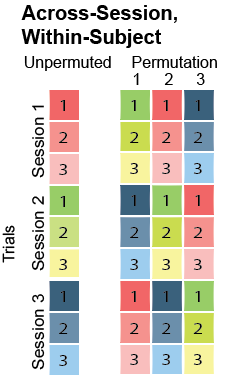

 **Figure 5B** in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time): A 9 x 4 matrix representing permutation testing across sessions. Each number corresponds to a trial within a session and permutations are performed between sessions, with each session containing the same number of trials.


**Hypothesis**
* Null Hypothesis (H0): No significant relationship exists between the independent variables and the dependent variable.
* Alternative Hypothesis (H1):: There is a significant relationship between the independent variables and the dependent variable.



### Across-sessions within subject testing - Regression<a id="perm-regression"></a>
In regression analysis, we are trying to explain the relationships between predictor variables (D) the response variable (R). Our goal is to identify the factors that contribute to changes in our signal over time. The permutation test for explained variance is a useful method to assess the statistical significance of relationships between state time courses (D) and behavioral measurements (R). A significant result indicates that certain patterns within the state time courses (```Gamma_reconstruct```) significantly contribute in explaining why the behavioral measurements varies across sessions. A non-significant result suggests that the observed relationship might just be a product of random chance. Simply put, the state time courses may not play a significant role in accounting for the variability of the behavioral measurements.


**Run the across_sessions_within_subject function:**\
To set the wheels in motion for the ```across_sessions_within_subject``` function, input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R). Additionally, you can account for potential confounding variables by regressing them out through permutation testing. Initiating regression-based permutation testing involves setting ```method="regression"```. For an in-depth comprehension of the function look at the documentation.

In [23]:
# Set the parameters for across sessions within subject testing
method = "regression"
Nperm = 1000 # Number of permutations (default = 0)
test_statistic = True
# Perform across-subject testing
result_regression_session  =statistics.test_across_sessions_within_subject(Gamma_reconstruct, R_sessions, idx_sessions,method=method,Nperm=Nperm, test_statistics_option=True)

performing permutation testing per timepoint


100%|██████████| 250/250 [00:47<00:00,  5.24it/s]


We can now examine the local ```result_regression_session``` variable.

In [24]:
result_regression_session

{'pval': array([0.94305694, 0.87112887, 0.88811189, 0.86013986, 0.9040959 ,
        0.74725275, 0.16883117, 0.36063936, 0.56143856, 0.998002  ,
        0.91108891, 0.63536464, 0.51348651, 0.53446553, 0.91108891,
        0.97402597, 0.85914086, 0.77522478, 0.9030969 , 0.77222777,
        0.77422577, 0.82017982, 0.89410589, 0.63136863, 0.41558442,
        0.22977023, 0.41658342, 0.98601399, 0.995005  , 0.8951049 ,
        0.87812188, 0.3956044 , 0.12387612, 0.06193806, 0.0959041 ,
        0.1038961 , 0.0999001 , 0.08991009, 0.05894106, 0.01498501,
        0.03496503, 0.08891109, 0.05594406, 0.01098901, 0.00699301,
        0.01298701, 0.002997  , 0.004995  , 0.000999  , 0.003996  ,
        0.004995  , 0.01898102, 0.01698302, 0.000999  , 0.001998  ,
        0.004995  , 0.002997  , 0.003996  , 0.003996  , 0.001998  ,
        0.000999  , 0.002997  , 0.000999  , 0.004995  , 0.01398601,
        0.01798202, 0.03896104, 0.05194805, 0.12187812, 0.28871129,
        0.31468531, 0.25274725, 0.276723

What we can see here is that ```result_regression_session``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array houses the p-values generated from the permutation test.

* ```corr_coef```: Currently an empty list, it is designated to store correlation coefficients if the analysis involves correlation. In this instance, correlation coefficients are not calculated when we set ```method="regression"```.

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```


* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_sessions_within_subject```.

* ```method```: method: Specifies the analytical method employed, which is ```'regression'```, which means that the analysis is carried out using regression-based permutation testing.

* ```Nperm```: Is the number of permutations that has been performed.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

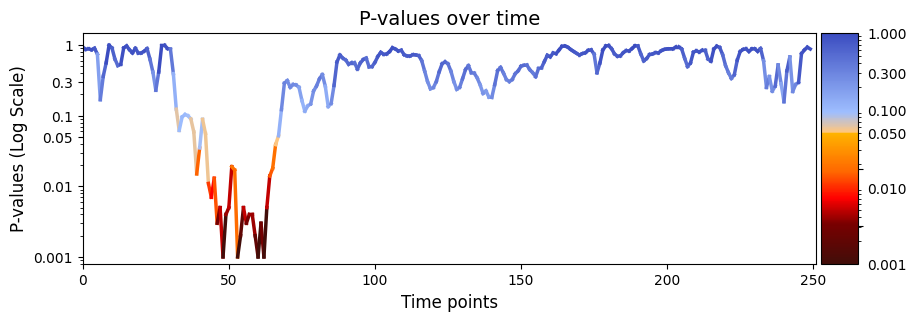

In [25]:
# The alpha score we set for the p-values
alpha = 0.05
# Plot p-values
graphics.plot_p_values_over_time(result_regression_session["pval"], title_text ="P-values over time",figsize=(10, 3), xlabel="Time points", alpha=alpha)

**Multiple Comparison**\
To take into account for type 1 error, we can apply the Bonferroni correction.

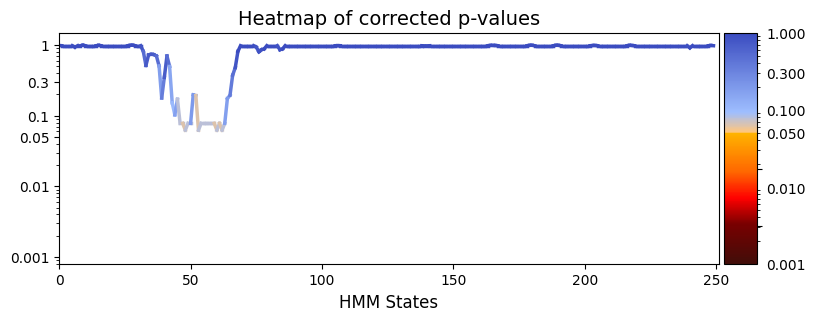

In [26]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_regression_session["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(9, 3), xlabel="HMM States", ylabel="")

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.
To use this p-value correction, set ```test_statistics_option=True``` while performing permutation testing, as it is an input to the function (```pval_cluster_based_correction```).

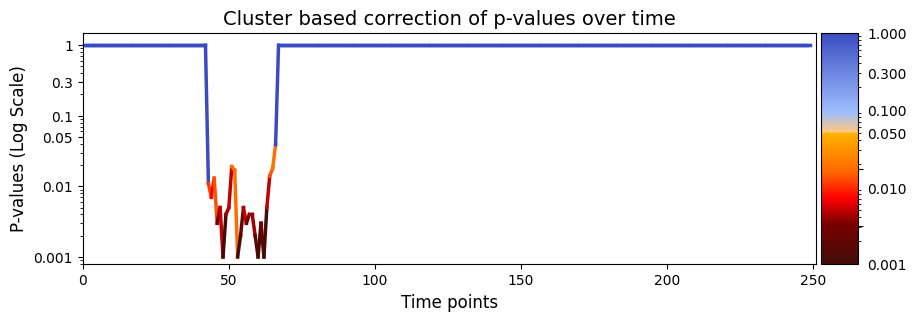

In [38]:
pval_cluster =statistics.pval_cluster_based_correction(result_regression_session["test_statistics"],result_regression_session["pval"])
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, title_text ="Cluster based correction of p-values over time",figsize=(10, 3), xlabel="Time points")

We can now compare if the results from ```result_regression_trials["pval"]``` correspond to the average probability for each state

intervals of significant p-values:
[(39, 40), (43, 66)]


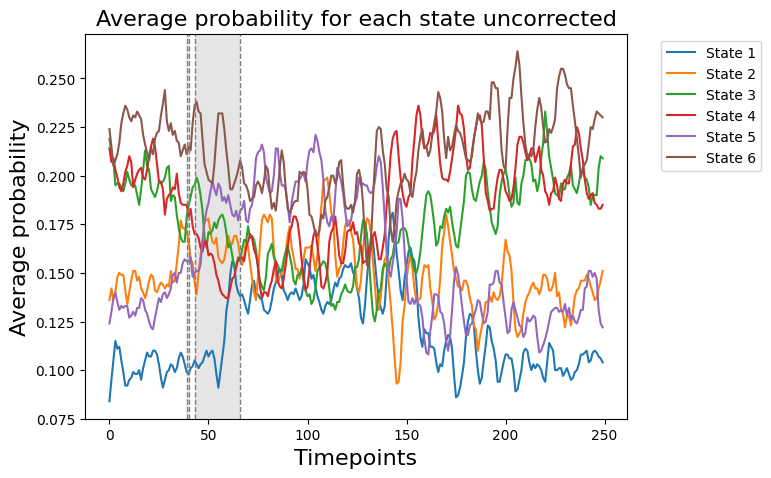

In [28]:
# Detect the intervals of when there is a significant difference, will be highlighed
alpha = 0.05
intervals =statistics.detect_significant_intervals(result_regression_session["pval"], alpha)
print(f"intervals of significant p-values:\n{intervals}")
title = "Average probability for each state uncorrected"
graphics.plot_average_probability(Gamma_reconstruct, vertical_lines=intervals, highlight_boxes=True, title=title)


Detect intervals of significant differences using the cluster based p value correction.

intervals of significant p-values:
[(43, 66)]


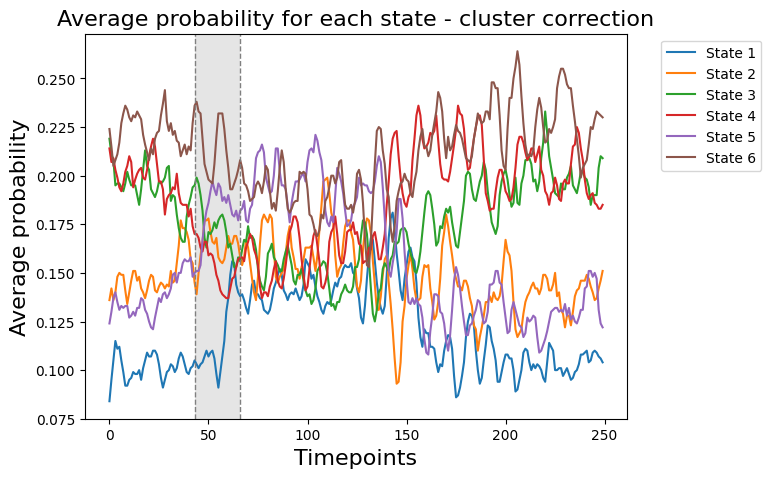

In [29]:
# Detect the intervals of when there is a significant difference, will be highlighed
alpha = 0.05
intervals =statistics.detect_significant_intervals(pval_cluster, alpha)
print(f"intervals of significant p-values:\n{intervals}")
title = "Average probability for each state - cluster correction"
graphics.plot_average_probability(Gamma_reconstruct, vertical_lines=intervals, highlight_boxes=True, title=title)


#### Conclusion - Regression session
In the permutation testing across sessions, we aimed to find out how state time courses (D) and reaction time (R) are related across various experimental sessions, all while keeping the trial order in the same. The analysis gave us a variable called ```pval```, packed with 250 p-values, each matching up with a specific time point in our experiment.

Now, the interesting bit: Statistically speaking, the test showed that different time windows (espicially timepoints 37 to 81 ) showed a significant difference and means that the state time courses (D) are related with changes in reaction time (R). In the context of an experiment, this could represent an important period of cognitive or neural processing relevant to the given task, depending on the experimental design.

### Across-trials within session testing - Regression<a id="perm-regression-trial"></a>
From our previous result, it is evident that there are variations at specific time windows across multiple sessions. This indicates significant changes occurring during each experimental session in which the subject is involved.

An intriguing aspect of this dataset is the opportunity to delve into trial-by-trial variability within each experimental session. Even though we observe a significant difference across sessions, it's possible that there are specific periods across trials that shows variability. This hypothesis can be tested using the function ```across_trials_within_session```.

**Run the across_trials_within_session function:**\
We do not need to change any input variables to run this test compare to earlier. Just insert input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R). Additionally, you can account for potential confounding variables by regressing them out through permutation testing. Initiating regression-based permutation testing involves setting ```method="regression"```. For an in-depth comprehension of the function look at the documentation.

Across-sessions within subject testing - Regression<a id="perm-regression"></a>

In [30]:
# Set the parameters for across sessions within subject testing
method = "regression"
Nperm = 1000 # Number of permutations (default = 1000)
test_statistics_option = True
# Perform across-subject testing
result_regression_trials  =statistics.test_across_trials_within_session(Gamma_reconstruct, R_sessions, idx_sessions,method=method,Nperm=Nperm, test_statistics_option=test_statistics_option)

performing permutation testing per timepoint


100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

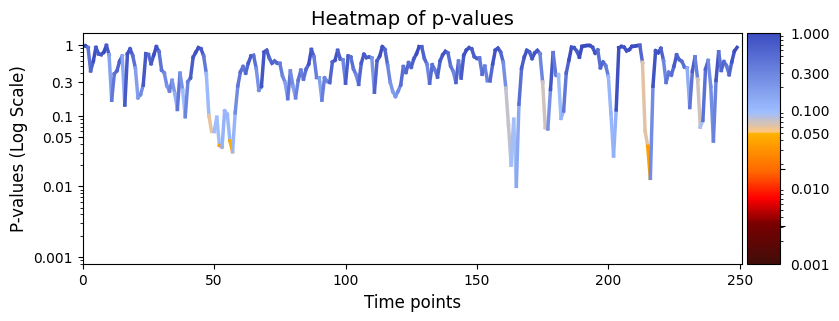

In [31]:
# Plot p-values
graphics.plot_p_values_over_time(result_regression_trials["pval"], title_text ="Heatmap of p-values",figsize=(9, 3), xlabel="Time points")

**Multiple Comparison**\
To take into account for type 1 error, we can apply the Benjamini/Hochberg correction.

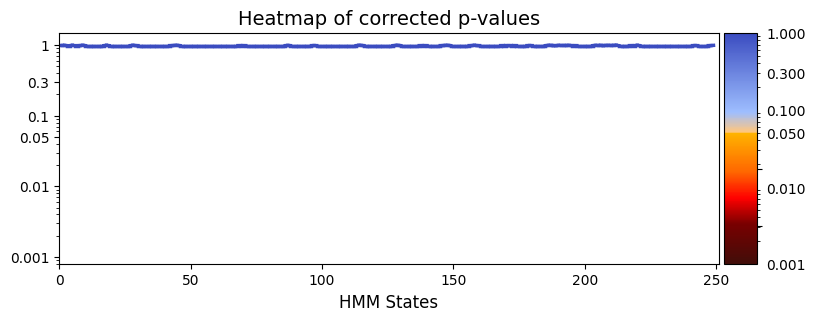

In [32]:
alpha = 0.05
pval_corrected, rejected_corrected =statistics.pval_correction(result_regression_trials["pval"], method='fdr_bh',alpha=alpha)
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(9, 3), xlabel="HMM States", ylabel="")

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.


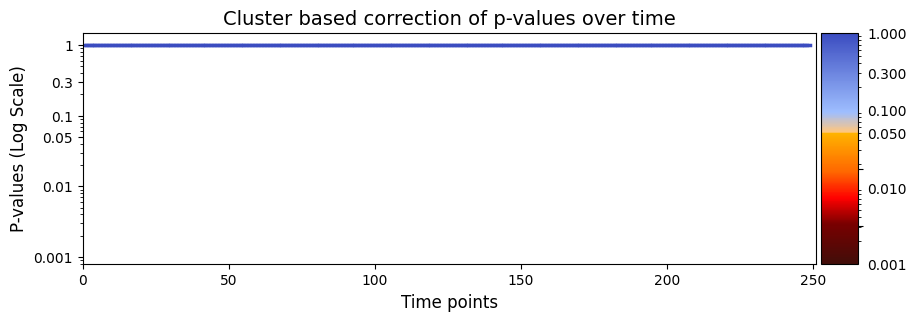

In [45]:
pval_cluster =statistics.pval_cluster_based_correction(result_regression_trials["test_statistics"],result_regression_trials["pval"])
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, title_text ="Cluster based correction of p-values over time",figsize=(10, 3), xlabel="Time points")

#### Conclusion - Regression trials
In the permutation testing across trials, we tried to find out the relationship between state time courses (D) and reaction time (R) throughout different trials within experimental sessions. 

There were no significant differences across the time points after correcting the p-values. This suggests a stable relationship between state time courses and reaction time throughout trials within each experimental session. This consistency implies that, on the given session or day, the subject's performance remains relatively unchanged/stable in terms of the observed state time courses and corresponding reaction times.\
This finding aligns well with how the data was constructed, as changes in reaction time were relatively consistent across trials within each session, but had varying values across different sessions.

Although the main goal of this tutorial was to look at variability within a subject between sessions, it is wise to also take trial-to-trial variability within a session into consideration. This additional test gives us a more complete picture of the data and helps us to account for any shifts in performance at a finer level of detail.

### Across-sessions within subject testing - Correlation<a id="perm-correlation"></a>
In correlation analysis, our goal is to explore the association between predictor variables (D) and the response variable (R). Our focus is on identifying the strength of the linear relationship between the state time courses  (```Gamma_reconstruct```) and behavioral measurements, such as 'reaction time'.\
If the result is significant, it means that certain patterns in the state time courses (```Gamma_reconstruct```) contributes in explaining the variability in behavioral measurements across sessions.
On the flip side, a non-significant result suggests that the observed relationship might just be a random thing, implying that our state time courses might not explain the variability in behavioral measurements.

**Executing the across_sessions_within_subject Function**:\
To initiate the across_sessions_within_subject function using correlation, input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R). Additionally, you can address potential confounding variables by incorporating permutation testing. Quick reminder: for correlation-based permutation testing, go with ```method="correlation"``` to get the correlation coefficients and p-values.


In [33]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_univariate =statistics.test_across_sessions_within_subject(Gamma_reconstruct, R_sessions, idx_sessions,method=method,Nperm=Nperm, test_statistics_option=True)

performing permutation testing per timepoint


100%|██████████| 250/250 [02:18<00:00,  1.80it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value matrix.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

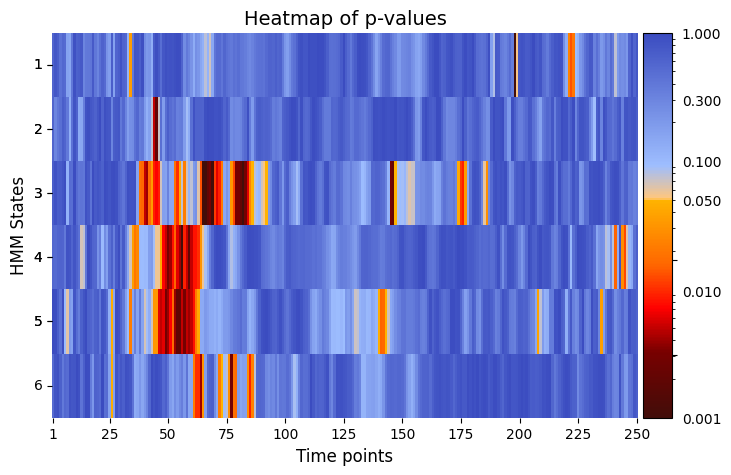

In [34]:
# Plot p-values
# Pvalues between reation time and each state as function of time
graphics.plot_p_value_matrix(result_univariate["pval"].T, title_text ="Heatmap of p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

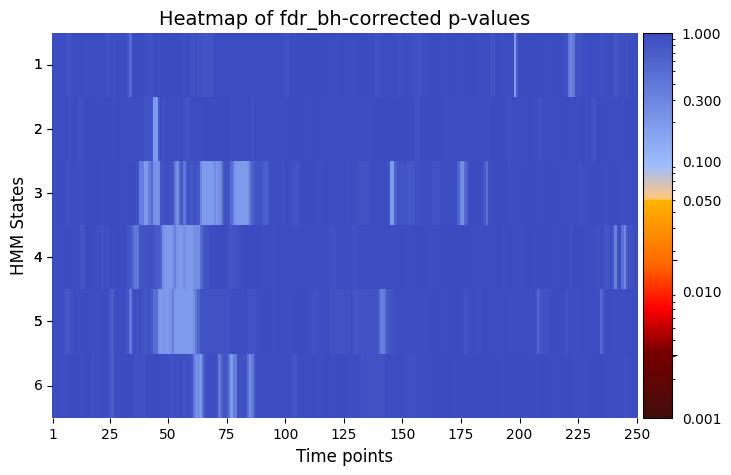

In [35]:
alpha = 0.05 # threshold for p-values
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], method='fdr_bh', alpha=0.5)
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, title_text ="Heatmap of fdr_bh-corrected p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False, alpha = alpha)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.

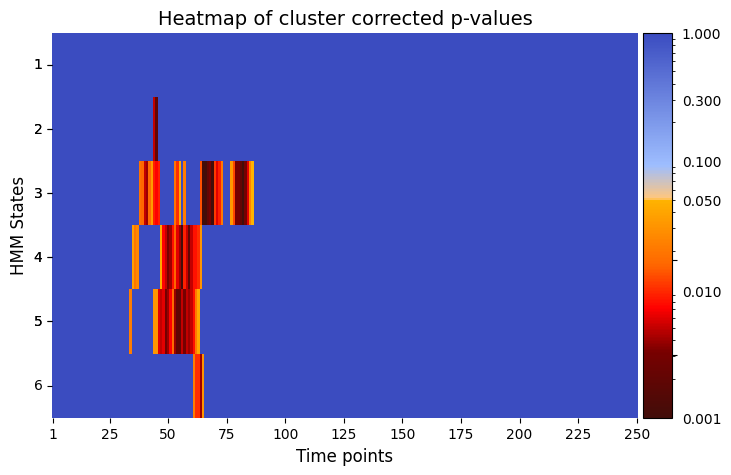

In [41]:
pval_cluster =statistics.pval_cluster_based_correction(result_univariate["test_statistics"],result_univariate["pval"])
# Plot p-values
graphics.plot_p_value_matrix(pval_cluster.T, title_text ="Heatmap of cluster corrected p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False, alpha = alpha)

We can now compare if the results from ```pval_cluster``` correspond to the average probability for each state

intervals of significant p-values:
[(33, 72), (76, 85)]


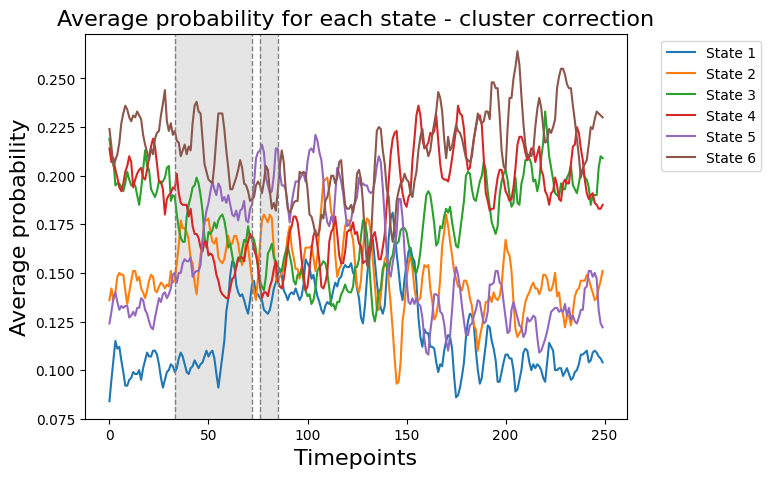

In [53]:
# Detect the intervals of when there is a significant difference, will be highlighed
alpha = 0.05
pval_cluster_1D=~np.sum(pval_cluster<alpha,axis=1).astype(bool)
intervals =statistics.detect_significant_intervals(pval_cluster_1D, alpha)
print(f"intervals of significant p-values:\n{intervals}")
title = "Average probability for each state - cluster correction"
graphics.plot_average_probability(Gamma_reconstruct, vertical_lines=intervals, highlight_boxes=True, title=title)


Plot Correlation Coefficients

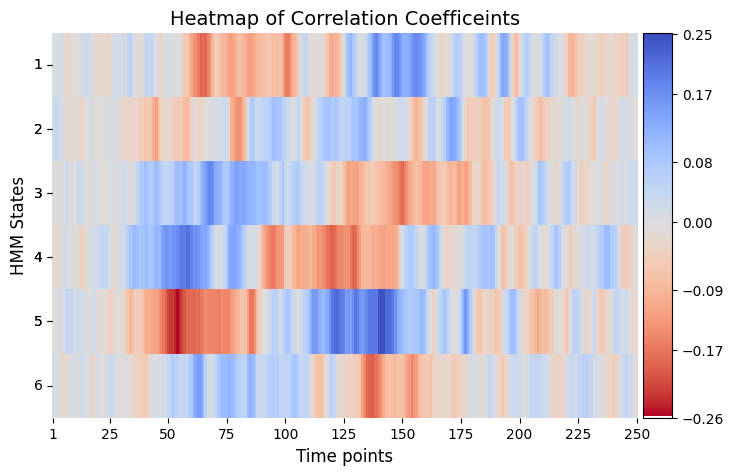

In [37]:
# Plot correlation coefficients
# Correlations between reation time and each state as function of time
graphics.plot_correlation_matrix(result_univariate["base_statistics"].T, result_univariate["performed_tests"], title_text ="Heatmap of Correlation Coefficeints",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False)

#### Conclusion - Correlation
The permutation testing analysis using correlation tries to find relationship between gamma values decoded from a HMM and reaction time across multiple experimental sessions. The resulting matrix, (```result_correlation["pval"]```), takes the form of (time points x states) and shows session-specific variations in the correlation between state time courses at specific timepoints and the simulated reaction time. Hence, it provides information for the time-dependent and state-specific correlation patterns.

A significant p-value for a particular HMM state and timepoint indicates that the correlation between state time courses (HMM state) at that specific time point and the presence of behavioral measurements significantly differs across experimental sessions. This shows that there are session-specific variations in that given time points or time windows.

We can see that the correlation are mainly between 33-85 time points before flattening out in the end. This absence of correlation towards the end of each trial makes sense, as this is when the signal plateaus or flattens out.

Nevertheless, it is crucial to contextualize these results within the framework of your experimental design and hypotheses. Differences in conditions during sessions may signify meaningful variations in correlation patterns relevant to the research questions. Therefore, interpreting the results in light of your experimental design is essential for a comprehensive understanding of the observed correlations.